In [6]:
import numpy as np 
import pandas as pd 

import os

In [7]:
# Paths to VOC directories
base_dir = '/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
images_dir = os.path.join(base_dir, 'JPEGImages')
annotations_dir = os.path.join(base_dir, 'Annotations')
sets_dir = os.path.join(base_dir, 'ImageSets/Main')

# Function to read predefined splits
def get_files_from_split(file_path):
    with open(file_path, 'r') as f:
        files = [x.strip().split()[0] for x in f.readlines() if not x.startswith('#')]
    return files

# Get all files from trainval.txt
trainval_files = get_files_from_split(os.path.join(sets_dir, 'trainval.txt'))
np.random.shuffle(trainval_files)  # Shuffle to randomize the split

split_index = int(len(trainval_files) * 0.9)
train_files = trainval_files[:split_index]
val_files = trainval_files[split_index:]

In [8]:
from torch.utils.data import Dataset
from PIL import Image
import os
import random
from torchvision import transforms

class RotationDataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        """
        file_list: lista dei nomi dei file (es. ['2008_000001', ...])
        root_dir: cartella dove sono le immagini JPEG
        """
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform
        
        # Mappa le rotazioni in classi
        self.angle_to_label = {0: 0, 90: 1, 180: 2, 270: 3}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.root_dir, filename + ".jpg")
        
        image = Image.open(img_path).convert("RGB")
        
        # 1. Scegliamo una rotazione casuale
        angle = random.choice([0, 90, 180, 270])
        
        # 2. Ruotiamo l'immagine
        # Nota: expand=True adatta la dimensione se l'img non è quadrata
        rotated_image = image.rotate(-angle, expand=True) 
        
        # 3. Creiamo la label per la rotazione
        label_rotation = self.angle_to_label[angle]
        
        # 4. Applichiamo le trasformazioni standard (Resize, ToTensor, Normalize)
        if self.transform:
            rotated_image = self.transform(rotated_image)
            
        return rotated_image, label_rotation

In [9]:
# Esempio di utilizzo
transform_pipeline = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Usa la tua lista 'train_files' generata nel tuo codice precedente
train_dataset = RotationDataset(train_files, images_dir, transform=transform_pipeline)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import time
import copy

# --- 1. CONFIGURAZIONE ---
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
PATIENTCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {DEVICE}")

# --- 2. DATALOADERS ---
# Creiamo il dataset di validazione (assicurati di aver definito val_files come prima)
val_dataset = RotationDataset(val_files, images_dir, transform=transform_pipeline)

# Creiamo i generatori di batch
# --- 2. DATALOADERS ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 3. DEFINIZIONE DEL MODELLO ---
# Scarichiamo una ResNet18 pre-addestrata
model = models.resnet50(pretrained=True)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 

# Congeliamo i pesi (facoltativo, ma velocizza se hai pochi dati)
# per un task semplice come la rotazione, spesso conviene NON congelare tutto, 
# ma se vuoi farlo:
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print(torch.cuda.device_count(), "devices")
    
model = model.to(DEVICE)

# --- 4. LOSS E OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# --- 5. FUNZIONE DI TRAINING ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=3 ):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Ogni epoca ha una fase di training e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Imposta il modello in modalità training
                dataloader = train_loader
            else:
                model.eval()   # Imposta il modello in modalità valutazione
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Itera sui dati
            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Azzera i gradienti dei parametri
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize solo se in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistiche
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.item() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Salva metriche
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

                # --- EARLY STOPPING LOGIC ---
                # Aggiorna lo scheduler
                scheduler.step()

                # Se la loss migliora, salviamo il modello e resettiamo il contatore
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    # print("  -> Miglioramento rilevato, modello salvato.")
                else:
                    epochs_no_improve += 1
                    print(f"  -> Nessun miglioramento per {epochs_no_improve}/{patience} epoche.")

        print() # Rigo vuoto tra epoche

        # Se non miglioriamo per 'patience' epoche, fermiamo tutto
        if epochs_no_improve >= patience:
            print(f"Early Stopping attivato! Nessun miglioramento per {patience} epoche consecutive.")
            break

    time_elapsed = time.time() - start_time
    print(f'Training completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model, history

# --- 6. AVVIO DEL TRAINING ---
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, patience=PATIENTCE)

# --- 7. SALVATAGGIO DEL MODELLO ---
torch.save(trained_model.state_dict(), 'fineTuning_resNet18_version2.pth')
print("Modello salvato come fineTuning_resNet18_version2.pth")

Usando device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


Epoch 1/30
----------
train Loss: 1.7120 Acc: 0.5831
val Loss: 0.6074 Acc: 0.7513

Epoch 2/30
----------
train Loss: 0.5611 Acc: 0.7837
val Loss: 0.4944 Acc: 0.8137

Epoch 3/30
----------
train Loss: 0.4855 Acc: 0.8116
val Loss: 0.5201 Acc: 0.7912
  -> Nessun miglioramento per 1/5 epoche.

Epoch 4/30
----------
train Loss: 0.4319 Acc: 0.8381
val Loss: 0.4178 Acc: 0.8518

Epoch 5/30
----------
train Loss: 0.4000 Acc: 0.8463
val Loss: 0.3776 Acc: 0.8657

Epoch 6/30
----------
train Loss: 0.3941 Acc: 0.8500
val Loss: 0.3497 Acc: 0.8718

Epoch 7/30
----------
train Loss: 0.3645 Acc: 0.8621
val Loss: 0.3908 Acc: 0.8562
  -> Nessun miglioramento per 1/5 epoche.

Epoch 8/30
----------
train Loss: 0.3664 Acc: 0.8622
val Loss: 0.3135 Acc: 0.8744

Epoch 9/30
----------
train Loss: 0.3353 Acc: 0.8734
val Loss: 0.2992 Acc: 0.8891

Epoch 10/30
----------
train Loss: 0.3326 Acc: 0.8759
val Loss: 0.3897 Acc: 0.8536
  -> Nessun miglioramento per 1/5 epoche.

Epoch 11/30
----------
train Loss: 0.3233 A

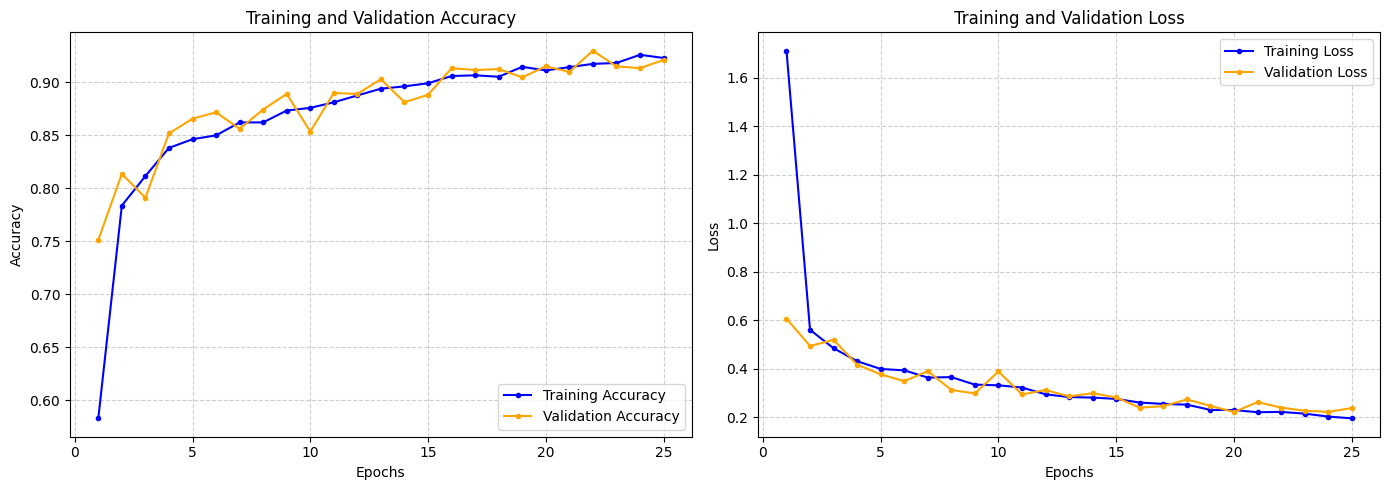

In [11]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    # Creiamo un array con il numero delle epoche effettive
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # --- GRAFICO 1: ACCURACY ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- GRAFICO 2: LOSS ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Esegui la funzione passando la history ottenuta dal training
if 'history' in locals():
    plot_training_results(history)
else:
    print("Errore: Variabile 'history' non trovata. Assicurati che la funzione di training la restituisca.")

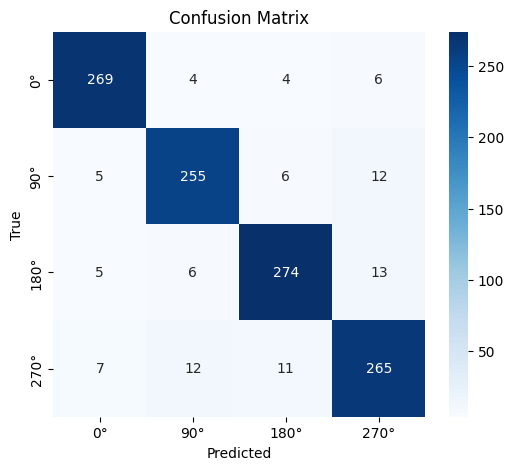

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, val_loader, class_names):
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move to CPU and append to lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot using Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names (based on your rotation angles)
class_names = ['0°', '90°', '180°', '270°']

# Run the confusion matrix function
plot_confusion_matrix(model, val_loader, class_names)

In [13]:
# --- 2. DATALOADERS ---
# Creiamo il dataset di test (assicurati di aver definito test_files come prima)
val_dataset = RotationDataset(val_files, images_dir, transform=transform_pipeline)

1. CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.9029    0.9472    0.9245       265
         90°     0.8990    0.9085    0.9037       284
        180°     0.9145    0.8997    0.9070       309
        270°     0.9193    0.8851    0.9019       296

    accuracy                         0.9090      1154
   macro avg     0.9089    0.9101    0.9093      1154
weighted avg     0.9092    0.9090    0.9089      1154

2. GENERATING GENERAL ROC CURVE


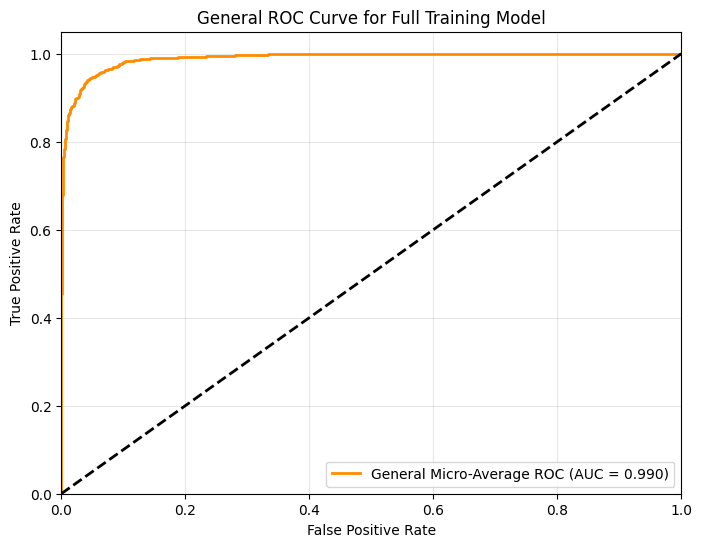

3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


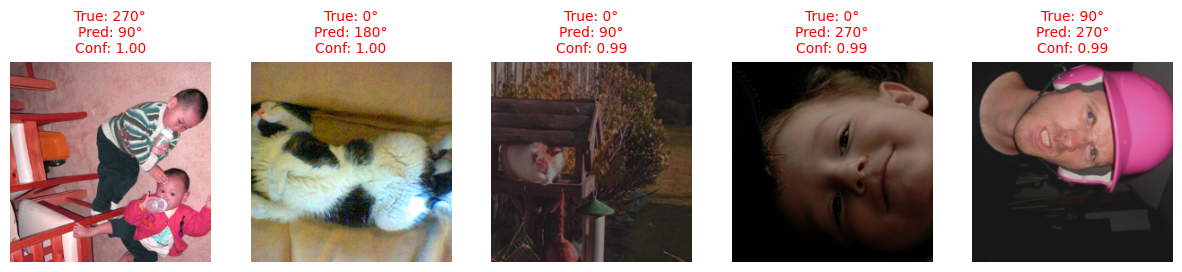

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import torch
import torch.nn.functional as F

def detailed_model_analysis(model, val_loader, class_names, device):
    model.eval()
    
    # Store all labels and outputs
    all_labels = []
    all_preds = []
    all_probs = [] # Raw probabilities for ROC
    
    # Store misclassified examples for visualization
    # Format: (probability, predicted_class, true_class, image_tensor)
    misclassified_examples = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # Apply Softmax to get probabilities (0 to 1)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            # Save data
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Collect errors for visualization
            # We look for cases where pred != label
            matches = preds.eq(labels)
            for i, is_correct in enumerate(matches):
                if not is_correct:
                    # Store data to visualize later
                    # We store the confidence score of the WRONG prediction
                    conf = probs[i][preds[i]].item()
                    misclassified_examples.append({
                        'conf': conf,
                        'pred': preds[i].item(),
                        'true': labels[i].item(),
                        'img': inputs[i].cpu()
                    })

    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    n_classes = len(class_names)

    # --- 1. Classification Report (F1, Precision, Recall) ---
    print("1. CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # --- 2. ROC Curves (One-vs-Rest) ---
    print("2. GENERATING GENERAL ROC CURVE")

    # Binarize labels (e.g., 0 -> [1, 0, 0, 0])
    y_true = np.array(all_labels)
    y_probs = np.array(all_probs)
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Compute Micro-Average ROC curve and ROC area
    # .ravel() flattens the arrays to calculate metrics globally across all classes
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'General Micro-Average ROC (AUC = {roc_auc:0.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line (random guess)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('General ROC Curve for Full Training Model')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # --- 3. Top-Confidence Errors (Visual Inspection) ---
    print("3. TOP CONFIDENT FAILURES (Visual Inspection)")
    print("These are images where the model was very confident but WRONG.")
    
    # Sort errors by confidence (descending)
    misclassified_examples.sort(key=lambda x: x['conf'], reverse=True)
    
    # Plot top 5 errors
    num_show = min(5, len(misclassified_examples))
    if num_show > 0:
        fig, axes = plt.subplots(1, num_show, figsize=(15, 4))
        if num_show == 1: axes = [axes]
        
        for i in range(num_show):
            data = misclassified_examples[i]
            
            # Un-normalize image for display
            # Assuming ImageNet stats: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            img = data['img'].clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            # Display
            ax = axes[i]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis('off')
            ax.set_title(f"True: {class_names[data['true']]}\nPred: {class_names[data['pred']]}\nConf: {data['conf']:.2f}", 
                         color='red', fontsize=10)
        plt.show()
    else:
        print("No errors found! (100% Accuracy)")

# --- Run the Analysis ---
class_names = ['0°', '90°', '180°', '270°']
detailed_model_analysis(trained_model, val_loader, class_names, DEVICE)